# 1. 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchinfo 


In [3]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=fd421752e1bff1de627577a63c1a2991ab9ea6cf968f69c60477d4b056b67ad1
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [17]:
import os
import random
import math #+
from typing import Tuple, Sequence, Callable
import csv
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.optim as optim
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader # torchvision.dataset의 데이터들을 불러온다.
from torchinfo import summary
from tqdm import tqdm
from torchvision import transforms
import albumentations as A # +
from torch.autograd import Variable # +
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models


* https://tutorials.pytorch.kr/beginner/nn_tutorial.html

In [5]:

device=torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')

#2. 커스텀 데이터셋 만들기 

In [6]:
class MnistDataset(Dataset):
    def __init__(
        self,
        dir: os.PathLike,
        image_ids: pd.DataFrame,
        transforms: Sequence[Callable]
    ) -> None:
        self.dir = dir
        self.transforms = transforms
        self.labels = {}

        for _, row in image_ids.iterrows():
          self.labels[int(row[0])] = list(map(int, row[1:]))

        self.image_ids = list(self.labels.keys())

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, index: int) -> Tuple[Tensor]:
        image_id = self.image_ids[index]
        image = Image. (
            os.path.join(
                self.dir, f'{str(image_id).zfill(5)}.png')).convert('')
        target = np.array(self.labels.get(image_id)).astype(np.float32)

        if self.transforms is not None:
            image = self.transforms(image)

        return {'image': image, 'label': target}

#3. 이미지 어그멘테이션 ( Flip Augmentation 제외 )

* https://dororongju.tistory.com/144
* from torchvision import transforms  이미지 변환 기능제공

In [7]:
# autoaugment 사용
!git clone https://github.com/DeepVoltaire/AutoAugment.git
!cp /content/AutoAugment/autoaugment.py /content

from PIL import Image, ImageEnhance, ImageOps
import matplotlib.pyplot as plt
import math
import random
import pdb
from autoaugment import ImageNetPolicy, CIFAR10Policy, SVHNPolicy, SubPolicy

Cloning into 'AutoAugment'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 140 (delta 0), reused 1 (delta 0), pack-reused 136
Receiving objects: 100% (140/140), 35.59 MiB | 26.55 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [8]:
transforms_train = transforms.Compose([ # 여러 transform들을 Compose로 구성할 수 있다.
    # transforms.RandomHorizontalFlip(p=0.5), # 
    # transforms.RandomVerticalFlip(p=0.5), # 적용시 알파벳 생김새가 겹칠 수 있는 가능성에 제거
    ImageNetPolicy(),
    transforms.ToTensor(), # PIL 이미지 또는 numpy.ndarray를 pytorch의 텐서로 변형시켜준다.
    transforms.Normalize( # 평균과 표준편차를 사용하여 이미지 정규화
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [9]:
# 시드 랜덤

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed) # pytorch의 random seed 고정
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore 

seed_everything(42)

* DataLoader Parameter : https://subinium.github.io/pytorch-dataloader/

#3. EfficientNet 모형

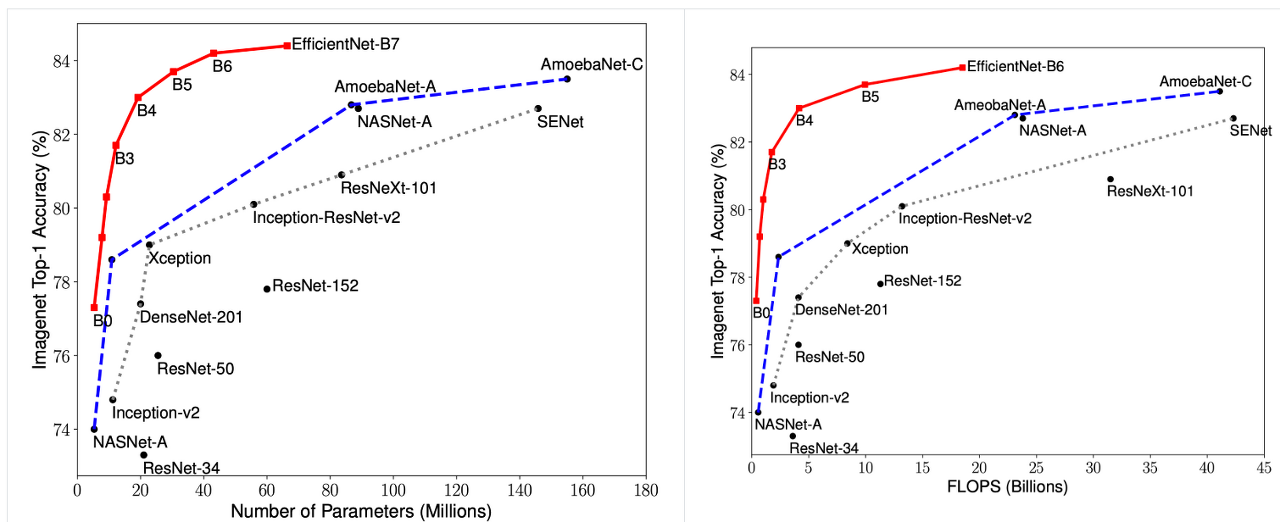

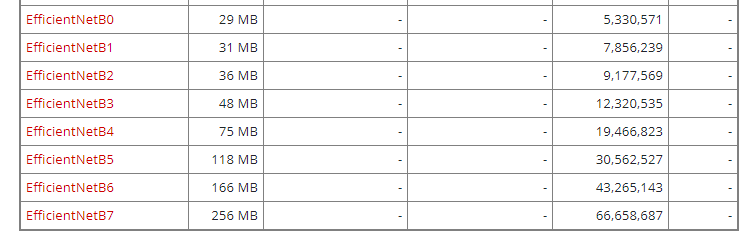

In [10]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.device(0))

True
0
1
Tesla T4


## 일단 빠른 속도에 좋은 성능의 EfficientNet B3 이용

In [11]:
from efficientnet_pytorch import EfficientNet

In [12]:
class MnistModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b7')
        self.classifier = nn.Linear(1000, 26)

        nn.init.xavier_normal_(self.classifier.weight)

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)

        return x

## Optimizer 선택 - AdamW or SAM Optimizer

In [ ]:
# class SAM(torch.optim.Optimizer):
#     def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
#         assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

#         defaults = dict(rho=rho, **kwargs)
#         super(SAM, self).__init__(params, defaults)

#         self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
#         self.param_groups = self.base_optimizer.param_groups

#     @torch.no_grad()
#     def first_step(self, zero_grad=False):
#         grad_norm = self._grad_norm()
#         for group in self.param_groups:
#             scale = group["rho"] / (grad_norm + 1e-12)

#             for p in group["params"]:
#                 if p.grad is None: continue
#                 e_w = p.grad * scale.to(p)
#                 p.add_(e_w)  # climb to the local maximum "w + e(w)"
#                 self.state[p]["e_w"] = e_w

#         if zero_grad: self.zero_grad()

#     @torch.no_grad()
#     def second_step(self, zero_grad=False):
#         for group in self.param_groups:
#             for p in group["params"]:
#                 if p.grad is None: continue
#                 p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

#         self.base_optimizer.step()  # do the actual "sharpness-aware" update

#         if zero_grad: self.zero_grad()

#     @torch.no_grad()
#     def step(self, closure=None):
#         assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
#         closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

#         self.first_step(zero_grad=True)
#         closure()
#         self.second_step()

#     def _grad_norm(self):
#         shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
#         norm = torch.norm(
#                 torch.stack([
#                   p.grad.norm(p=2).to(shared_device)
#                     for group in self.param_groups for p in group["params"]
#                       if p.grad is not None
#                     ]),
#                     p=2
#                )
#         return norm

# 4. Learning rate scheduler: None or CosineAnnealingWithWarmRestarts 

* https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup/blob/master/cosine_annearing_with_warmup.py

* https://ai4nlp.tistory.com/8


In [13]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

* warmup 후에는 코사인 함수를 이용하여 Learning rate를 scaling하는 방식입니다. t_curr은 현재 주기 범위 내의 업데이트 비율이며 t_i는 현재 주기 범위입니다.

* lr = lr_min + 0.5*(lr_max - lr_min)*(1 + cos(t_cur / t_i))

#6. 학습하기

In [14]:
 train_path='/content/drive/MyDrive/DACON/월간데이콘/12/data/train'
 test_path='/content/drive/MyDrive/DACON/월간데이콘/12/data/test'

 train_answer='/content/drive/MyDrive/DACON/월간데이콘/12/data/dirty_mnist_2nd_answer.csv'
 dirty_mnist_answer = pd.read_csv(train_answer)

In [15]:
num_epochs = 100
torch.cuda.empty_cache()

In [16]:
EARLY_STOPPING_EPOCH = 5
SEED = 42

# cross validation을 적용하기 위해 KFold 생성
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)

# dirty_mnist_answer에서 train_idx와 val_idx를 생성
best_models = [] # 폴드별로 가장 validation acc가 높은 모델 저장
# validaion loss가 감소할 때 마다 모델 저장
valid_loss_min = 100

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer),1):

  seed_everything(SEED)
  print(f'[fold: {fold_index}]')
  # cuda cache 초기화
  torch.cuda.empty_cache()

  #train fold, validation fold 분할
  train_answer = dirty_mnist_answer.iloc[trn_idx]
  valid_answer  = dirty_mnist_answer.iloc[val_idx]

  #Dataset 정의
  train_dataset = MnistDataset(train_path, train_answer, transforms_train)
  valid_dataset = MnistDataset(train_path, valid_answer, transforms_test)

  #DataLoader 정의
  train_data_loader = DataLoader(
      train_dataset,
      batch_size = 128,
      shuffle = False,
      num_workers = 8
  )
  valid_data_loader = DataLoader(
      valid_dataset,
      batch_size = 32,
      shuffle = False,
      num_workers = 4
  )

  model = MnistModel()
  model.to(device)# gpu에 모델 할당

  optimizer = optim.AdamW(model.parameters(), lr=0.001)
  lr_sched = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001, last_epoch=-1)
  criterion = nn.MultiLabelSoftMarginLoss()

  valid_acc_max = 0
  valid_early_stop = 0
  valid_best_loss = float('inf')

  for epoch in range(num_epochs):
    train_acc_list = []
    with tqdm(train_data_loader,
        total=train_data_loader.__len__(), 
        unit="batch") as train_bar:
        for sample in train_bar:
          train_bar.set_description(f"Train Epoch {epoch}")
        
          
          optimizer.zero_grad()

          images, labels = sample['image'], sample['label']
          
          images = images.to(device)
          labels = labels.to(device)
          model.train()

          
          with torch.set_grad_enabled(True):
            outputs = model(images) # 모델 예측
            loss = criterion(outputs, labels) # loss 계산

            loss.backward()
            optimizer.step()
            
            # train accuracy 계산
            outputs  = outputs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            preds = outputs > 0.5
            batch_acc = (labels == preds).mean()
            train_acc_list.append(batch_acc)
            train_acc = np.mean(train_acc_list)
          # 현재 progress bar에 현재 미니배치의 loss 결과 출력
          train_bar.set_postfix(train_loss= loss.item(),
                            train_acc = train_acc)

    valid_acc_list = []

    with tqdm(valid_data_loader,
          total=valid_data_loader.__len__(),
          unit="batch") as valid_bar:

          for sample in valid_bar:
            valid_bar.set_description(f"Valid Epoch {epoch}")
            
              
            optimizer.zero_grad()
            images, labels = sample['image'], sample['label']
            images = images.to(device)
            labels = labels.to(device)
            
            model.eval()
            
            with torch.no_grad():

              probs  = model(images)
              valid_loss = criterion(probs, labels)


              # validation accuracy 계산
              probs  = probs.cpu().detach().numpy()
              labels = labels.cpu().detach().numpy()
              preds = probs > 0.5
              batch_acc = (labels == preds).mean()
              valid_acc_list.append(batch_acc)
              valid_acc = np.mean(valid_acc_list)

            valid_bar.set_postfix(valid_loss = valid_loss.item(),
                                  valid_acc = valid_acc)
          
    # early stopping    
    if valid_loss.item() < valid_best_loss:
      valid_best_loss = valid_loss.item()
      valid_early_stop = 0
    else:
      valid_early_stop += 1
      if valid_early_stop >= EARLY_STOPPING_EPOCH:
        print("EARLY_STOPPING!!")
        break


    # Learning rate 조절
    lr_sched.step()

    # 모델 저장
    if (valid_loss.item()  < 0.2) or (valid_acc_max < valid_acc):
      best_model = model
      MODEL = f"efficientnet7_rs{SEED}"
      # 경로 설정 필요
      path = f"/content/drive/MyDrive/DACON/월간데이콘/12/efficientnet7_rs{SEED}/"
      try: 
        os.mkdir(path)
      except:
        None 
      torch.save(best_model.state_dict(), f'{path}{fold_index}_{MODEL}_{valid_loss.item():2.4f}_epoch_{epoch}.pth')

  # 폴드별로 가장 좋은 모델 저장
  best_models.append(best_model)

[fold: 1]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/ef


Loaded pretrained weights for efficientnet-b7


  0%|          | 0/313 [02:00<?, ?batch/s]


OSError: ignored

In [ ]:
model = MnistModel()
model.to(device)# gpu에 모델 할당
import copy
best_models = []
model.load_state_dict(torch.load('1st fold'))
best_models.append(copy.deepcopy(model))
model.load_state_dict(torch.load('2nd fold'))
best_models.append(copy.deepcopy(model))
model.load_state_dict(torch.load('3th fold'))
best_models.append(copy.deepcopy(model))
model.load_state_dict(torch.load('4th fold'))
best_models.append(copy.deepcopy(model))
model.load_state_dict(torch.load('5th fold'))
best_models.append(copy.deepcopy(model))



In [ ]:
transforms_test1 = transforms.Compose([
                                      
    transforms.RandomHorizontalFlip(p=0),
    transforms.RandomVerticalFlip(p=0),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

transforms_test2 = transforms.Compose([
                                      
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=0),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

transforms_test3 = transforms.Compose([
                                      
    transforms.RandomHorizontalFlip(p=0),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

transforms_test4 = transforms.Compose([
                                      
    transforms.RandomHorizontalFlip(p=0),
    transforms.RandomVerticalFlip(p=0),
    ImageNetPolicy(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

#test Dataset 정의
sample_submission = pd.read_csv("/content/sample_submission.csv")
test_df = pd.read_csv('/content/sample_submission.csv')
test_dataset1 =  MnistDataset('/content/test_dirty_mnist', test_df, transforms_test1) 
test_dataset2 =  MnistDataset('/content/test_dirty_mnist', test_df, transforms_test2) 
test_dataset3 =  MnistDataset('/content/test_dirty_mnist', test_df, transforms_test3) 
test_dataset4 =  MnistDataset('/content/test_dirty_mnist', test_df, transforms_test4) 

batch_size = 32
test_data_loader1 = DataLoader(
    test_dataset1,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4,
    drop_last = False
)
test_data_loader2 = DataLoader(
    test_dataset2,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4,
    drop_last = False
)
test_data_loader3 = DataLoader(
    test_dataset3,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4,
    drop_last = False
)
test_data_loader4 = DataLoader(
    test_dataset4,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4,
    drop_last = False
)


#5. Submission


In [ ]:
predictions_list = []
prediction_df = pd.read_csv("/content/drive/MyDrive/DACON/월간데이콘/12/data/sample_submission.csv")

# 4개의 data_loader를 모두 사용 (TTA)
for test_data_loader in [test_data_loader1, test_data_loader2, test_data_loader3, test_data_loader4]:
  # 5개의 fold마다 가장 좋은 모델을 이용하여 예측
  for model in best_models:
      prediction_array = np.zeros([prediction_df.shape[0],
                                prediction_df.shape[1] -1])      
      for idx, sample in enumerate(test_data_loader):
          with torch.no_grad():

              model.eval()
              images = sample['image']
              images = images.to(device)
              probs  = model(images)
              probs = torch.sigmoid(probs).cpu().detach().numpy()

              prediction_array[idx*batch_size: (idx+1)*batch_size ,:]\
                          = probs.astype(np.float32)
                          
      # 채널을 하나 추가하여 list에 append
      predictions_list.append(prediction_array[...,np.newaxis])
  
# axis = 2를 기준으로 평균 (TTA, folds for each SEED)
predictions_array = np.concatenate(predictions_list, axis = 2)
predictions_mean = predictions_array.mean(axis = 2)

# 평균 값이 0.5보다 클 경우 1 작으면 0
predictions_mean = (predictions_mean > 0.5) * 1
predictions_mean

sample_submission = pd.read_csv("/content/drive/MyDrive/DACON/월간데이콘/12/data/sample_submission.csv")
sample_submission.iloc[:,1:] = predictions_mean
sample_submission.to_csv(f'perfect_efficientnetb7_rs{SEED}.csv', index = False) # 경로 수정 필요
sample_submission